In [95]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import george
from george.kernels import ExpSquaredKernel, WhiteKernel
import pandas as pd
import emcee
from MCMC_plots import make_plot
import time
import h5py
import os
from teff_bv import teff2bv
import barnes as bn

RESULTS_DIR = "results"
DATA_DIR = "data"

Load the data.

In [96]:
def load_data():
    
    # load clusters
    bv1, bv_err1, p, p_err, a, a_err, logg, logg_err, f = \
        np.genfromtxt(os.path.join(DATA_DIR, "clusters.txt")).T
    
    # load precise astero
    data = pd.read_csv(os.path.join(DATA_DIR, "vansaders.txt"))
    bv2 = teff2bv(data["Teff"], data["AMP_logg"], data["FeH"])
    bv_err2 = np.ones_like(bv2)*.1
    
    df = pd.read_csv(os.path.join(DATA_DIR, "chaplin_garcia.csv"))
    dfbvs = teff2bv(df["teff"], df["logg"], df["feh"])
    
    # load all other astero stars and concatenate
    age = np.concatenate((a, np.array(data["AMP_age"]), df["age"]))
    age_err = np.concatenate((a_err, np.array(data["AMP_age_err"]), .5*(df["age_errp"] + df["age_errm"])))
    period = np.concatenate((p, np.array(data["period"]), df["period"]))
    period_err = period * .1
    bv = np.concatenate((bv1, bv2, dfbvs))
    bv_err = np.concatenate((bv_err1, bv_err2, np.ones_like(dfbvs)*.1))
    logg = np.concatenate((np.ones_like(bv1)*4.4, data["AMP_logg"], df["logg"]))
    feh = np.concatenate((np.ones_like(bv1)*0., data["FeH"], df["feh"]))
    
    # remove very red stars
    m = (.4 < bv ) * (bv < 1.2) * (logg > 4.)
    return age[m], age_err[m], bv[m], bv_err[m], period[m], period_err[m], logg[m], feh[m]

In [97]:
age, age_err, bv, bv_err, period, period_err, logg, feh = load_data()

Plotting function.

In [98]:
def plot_2d_prediction(theta, x, y, xerr, yerr, myx, myz, mu, v, xlabel, ylabel, zlabel):
    
    plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt="k.")
    plt.errorbar(myx, mu, yerr=v, fmt="r.", ms=10)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)        
    xplot = np.linspace(min(x), max(x), 100)
    k = theta[0]**2 * ExpSquaredKernel(theta[1]**2)
    gp = george.GP(k)
        
    bv, period = x, myz
    model_xplot_shape = gyro_age(theta, period, xplot)
    if type(myz) == "bool":
        bv, period = myz, xplot
        model_xplot_shape = gyro_age(theta, xplot, bv)
    model_y_shape = gyro_age(theta, period, bv)
    gp.compute(x, (yerr**2 + theta[3]**2)**.5)
    mus, covs = gp.predict(y - model_y_shape, xplot)  # do the prediction
    vs = np.diag(covs)**.5
    plt.plot(xplot, mus + model_xplot_shape, label=(zlabel))
    plt.fill_between(xplot, mus + model_xplot_shape - vs - theta[3], 
                     mus + model_xplot_shape + vs + theta[3], alpha=.2)
    plt.legend(loc="best")
    plt.show()

The gyrochronology model.

In [99]:
def gyro_age(pars, period, bv):
    """
    Calculates an age from a rotation period and colour.
    Parameters
    ----------
    pars: array or list
        gyrochronology parameters [a, b, n]
        barnes params are a, b, c, n = .7725, .601, .4, .5189
    period : array_like[nsamples]
        Rotation period in days.
    bv: array_like[nsamples]
        B-V color.
    Returns:
        Age in Gyr.
    """
    return (period / pars[4] * (bv - .4) ** pars[5]) ** pars[6]

Set initial parameters.

In [100]:
A, lbv, lp, sigma = 10, 2000, 50, 1.
a, b, n = .7725, .601, .5189
theta_init = np.log(np.array([A, lbv, lp, sigma, a, b, n]))  # initial guess

Define prior, lnlike + lnprob.

In [101]:
def lnprior(theta):  # very broad uniform log prior
    if -20 < theta[0] < 20 and -20 < theta[1] < 20 and -20 < theta[2] < 20 and -20 < theta[3] < 20 \
        and -20 < theta[4] < 20 and -20 < theta[5] < 20 and -20 < theta[6] < 20:
        return 0.
    return -np.inf

In [102]:
def lnlike(theta, x, y, z, yerr, mean_model=True):
    theta = np.exp(theta)
    D = np.vstack((x, z)).T
    k = theta[0]**2 * ExpSquaredKernel([theta[1]**2, theta[2]**2], ndim=2)
    gp = george.GP(k)
    try:
        gp.compute(D, (yerr**2 + theta[3]**2)**.5)
    except (ValueError, np.linalg.LinAlgError):
        return 10e25
    if mean_model:
        r = y - gyro_age(theta, z, x)
        m = np.isfinite(r)
        if len(r) > len(r[m]):
            return -np.inf
        return gp.lnlikelihood(r, quiet=True)
    return gp.lnlikelihood(y, quiet=True)

In [103]:
def lnprob(theta, x, y, z, yerr):
    return lnlike(theta, x, y, z, yerr) + lnprior(theta)

Set up MCMC.

In [104]:
x, y, z, yerr = bv, age, period, age_err
burnin, nwalkers, ndim = 5000, 24, len(theta_init)
runs = np.zeros(5) + 5000
p0 = [theta_init+1e-4*np.random.rand(ndim) for i in range(nwalkers)]
args = (x, y, z, yerr)

Time it.

In [105]:
start = time.time()
print("lnprob = ", lnprob(theta_init, x, y, z, yerr))
end = time.time()
tm = end - start
print("1 lhf call takes ", tm, "seconds")
print("burn in will take", tm * nwalkers * burnin, "s")
print("each run will take", tm * nwalkers * sum(runs)/60, "mins")
print("total = ", (tm * nwalkers * sum(runs) + tm * nwalkers * burnin)/60, "mins")

lnprob =  -796.02894204
1 lhf call takes  0.006220102310180664 seconds
burn in will take 746.4122772216797 s
each run will take 62.2010231018 mins
total =  74.6412277222 mins


Run the MCMC.

burning in..., 5000 steps


/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


production run, 5000 steps
time taken =  11.227215333779652 minutes

 0.926907041962 period (days) 

[  0.3284693   -2.574184    -0.04168101 -11.14413719   1.55504901
 -11.49493992  -0.075902  ]
Plotting traces


/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:23: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Making triangle plot
plotting prediction
production run, 5000 steps
time taken =  12.544491998354594 minutes

 0.932557550491 period (days) 

[  0.32460831  -2.58048196  -0.04472541 -11.10231084   1.580959
 -11.57811055  -0.06982441]
Plotting traces
Making triangle plot
plotting prediction
production run, 5000 steps
time taken =  11.861143851280213 minutes

 0.933434303272 period (days) 

[  0.32483834  -2.57870714  -0.04513142 -11.05890024   1.58819698
 -11.51711122  -0.0688847 ]
Plotting traces
Making triangle plot
plotting prediction
production run, 5000 steps
time taken =  12.211451685428619 minutes

 0.933922828436 period (days) 

[  0.32420831  -2.57912055  -0.04562466 -10.94648869   1.58593536
 -11.26752649  -0.06836147]
Plotting traces
Making triangle plot
plotting prediction
production run, 5000 steps
time taken =  11.963172785441081 minutes

 0.93113086874 period (days) 

[  0.32261278  -2.58147044  -0.04667533 -11.00184872   1.58038902
 -11.24038288  -0.07135544]
Plotting tr

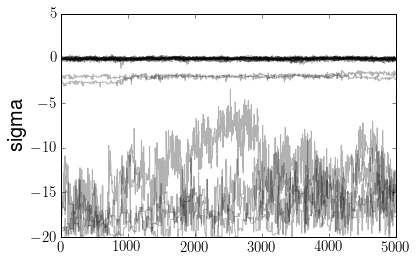

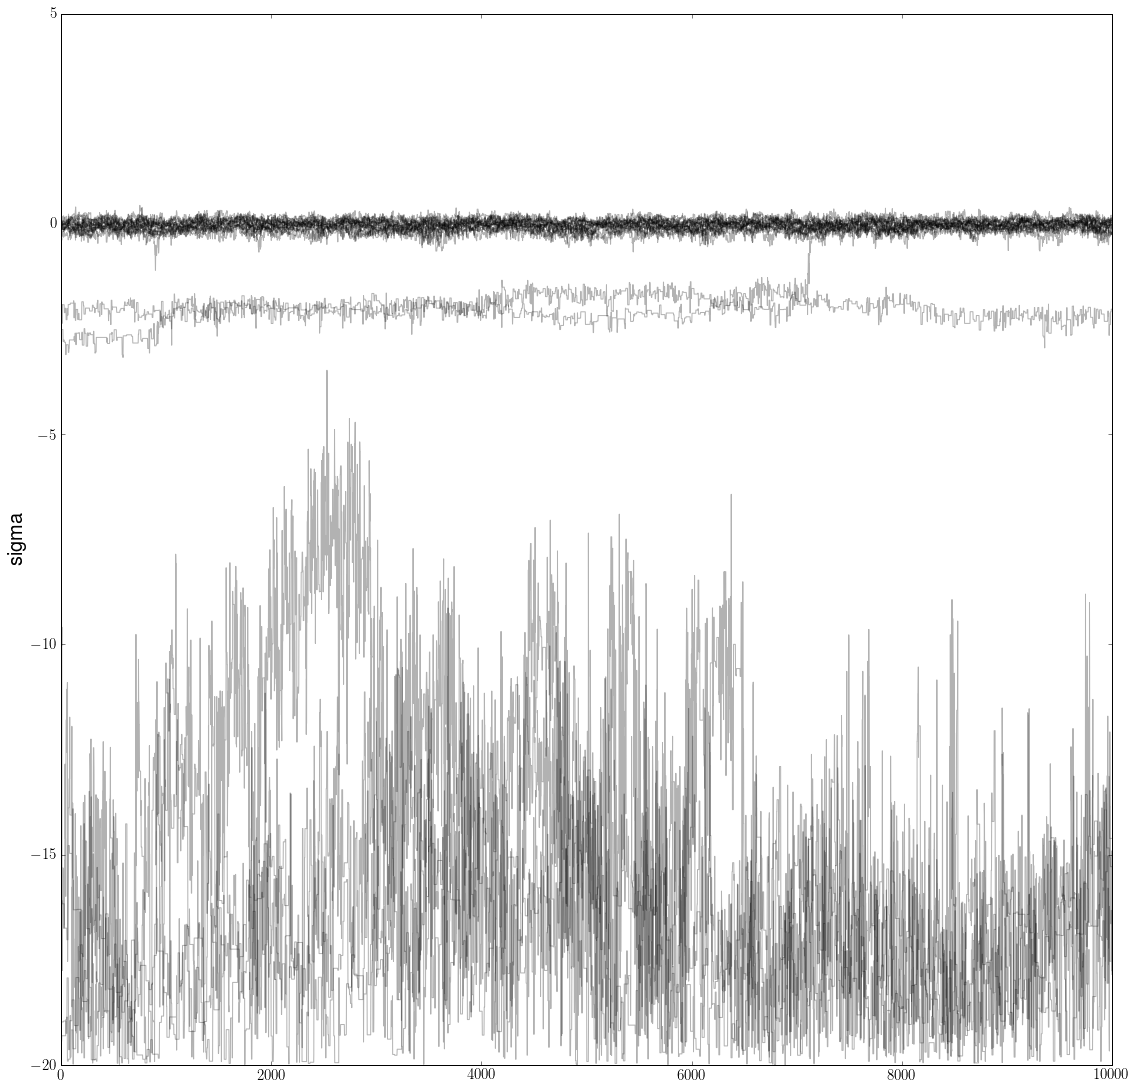

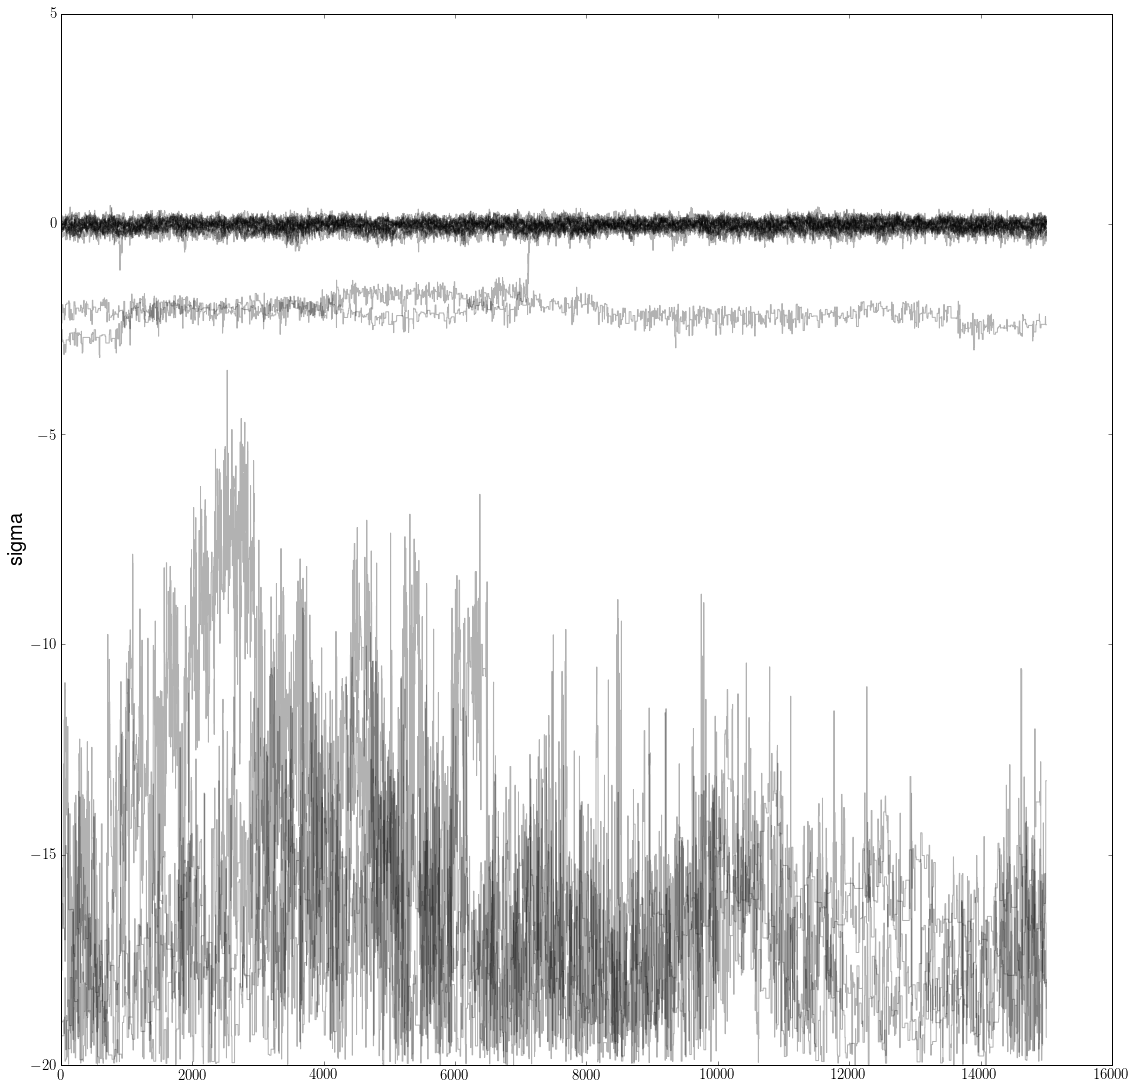

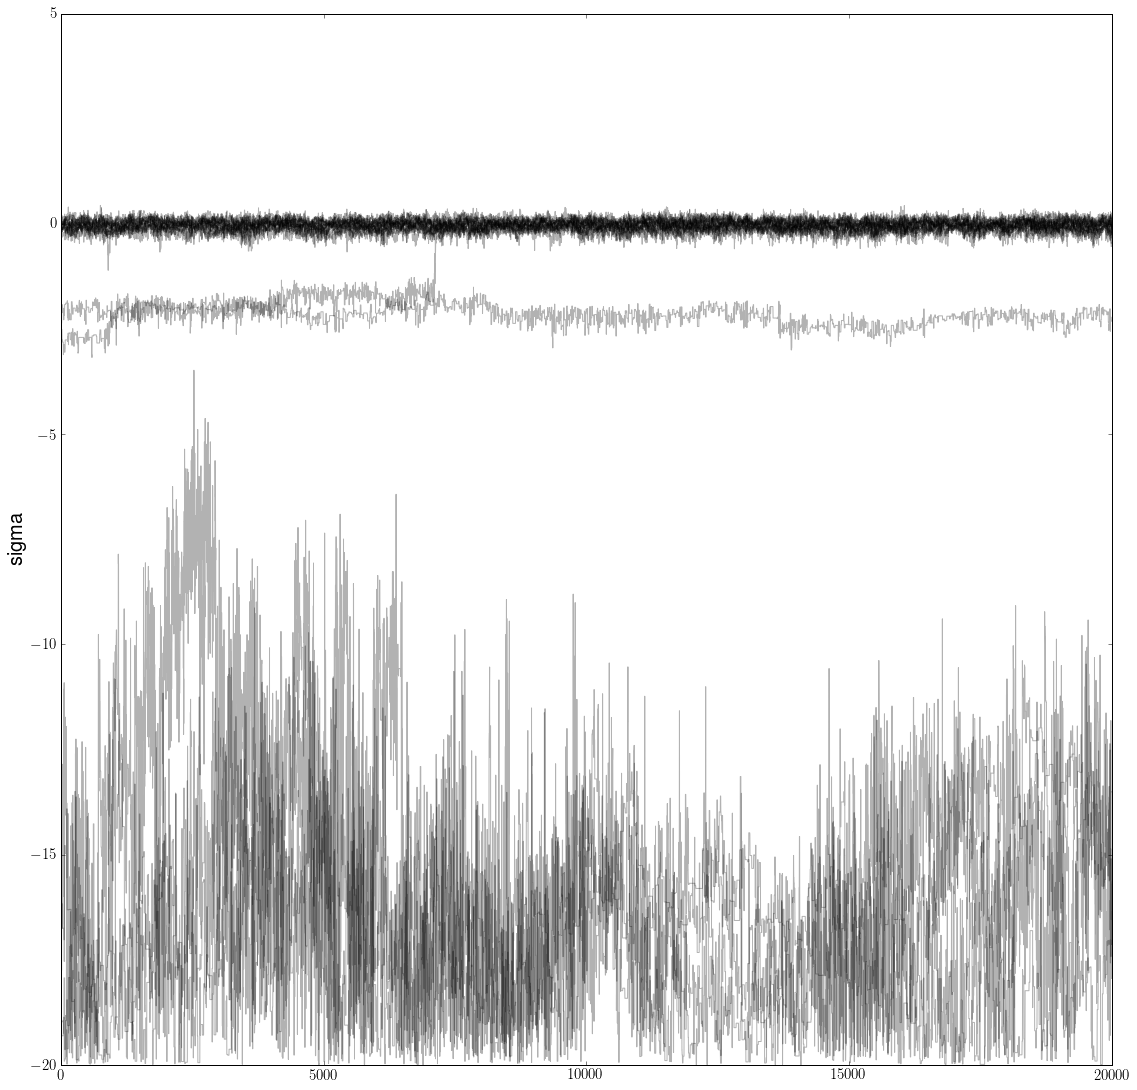

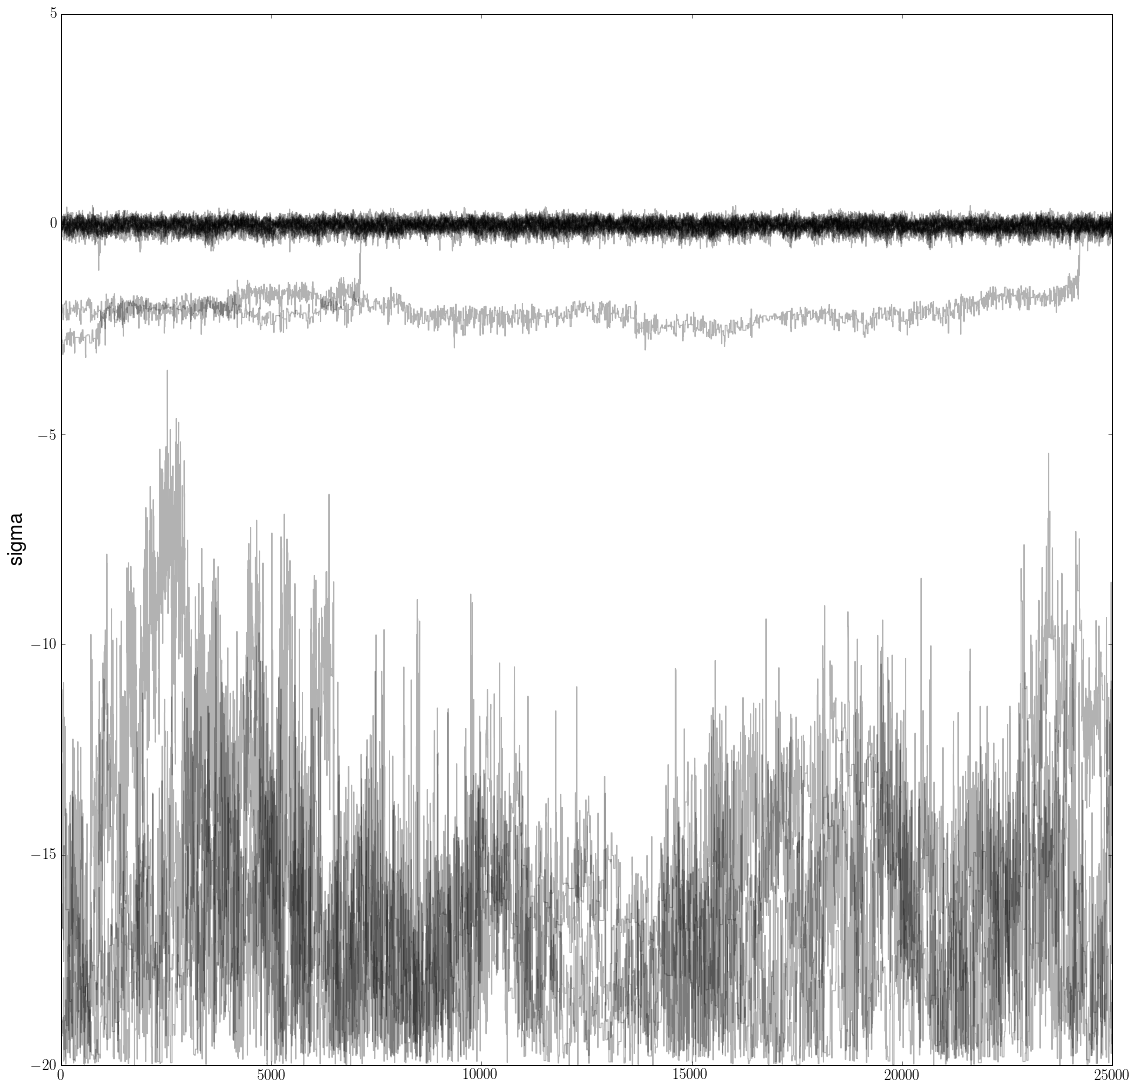

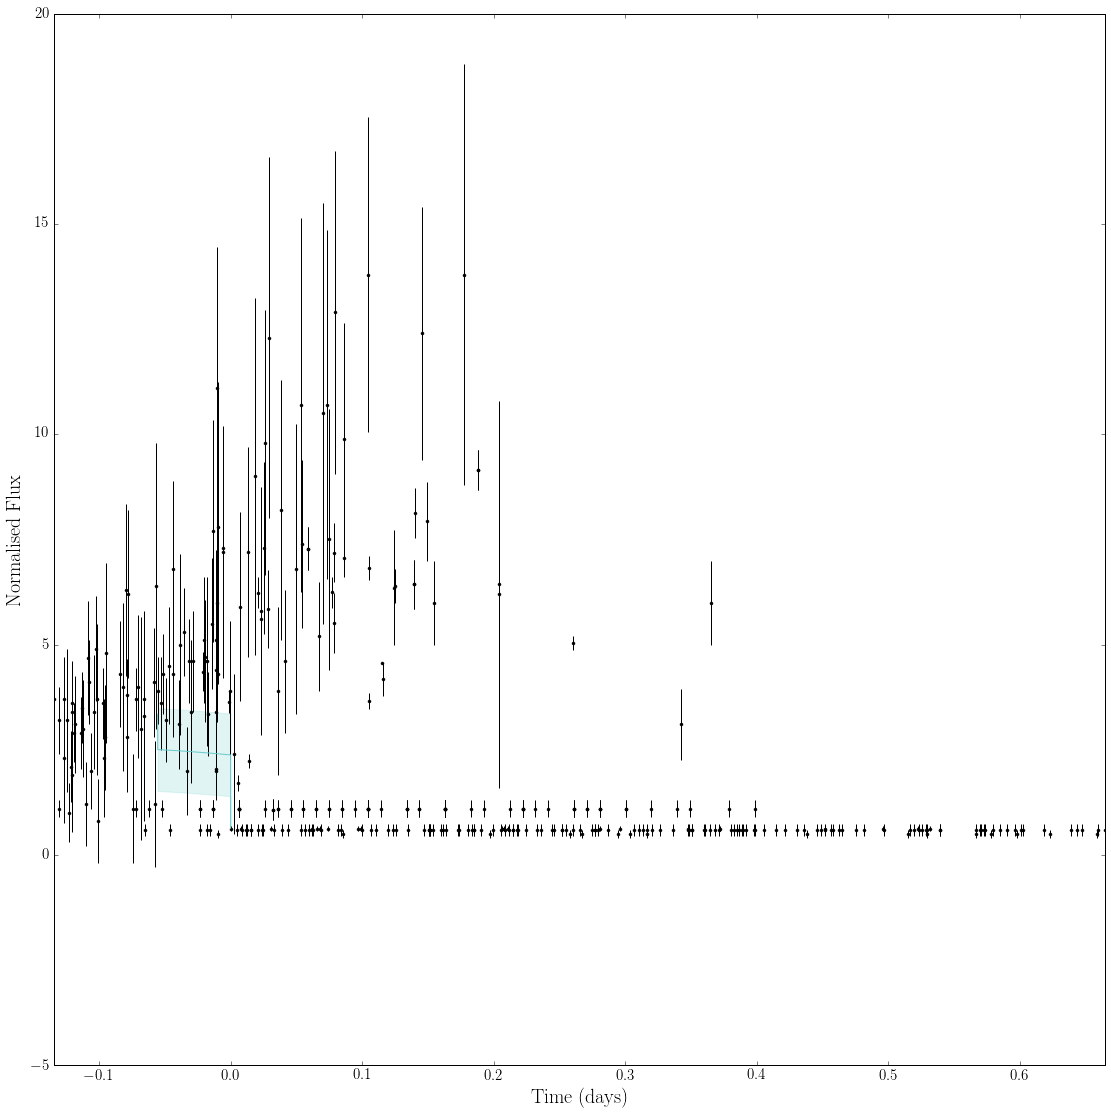

In [106]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=args)
print("burning in..., {0} steps".format(int(burnin)))
p0, _, state = sampler.run_mcmc(p0, burnin)
fig_labels = ["a", "b", "n", "A", "lbv", "lp", "sigma"]

sample_array = np.zeros((nwalkers, sum(runs), ndim))
for i, run in enumerate(runs):
    sampler.reset()
    print("production run, {0} steps".format(int(run)))
    start = time.time()
    p0, _, state = sampler.run_mcmc(p0, run)
    end = time.time()
    print("time taken = ", (end - start)/60, "minutes")
    
    # save samples
    sample_array[:, sum(runs[:i]):sum(runs[:(i+1)]), :] = np.array(sampler.chain)
    f = h5py.File(os.path.join(RESULTS_DIR, "3D_free_params_samples.h5"), "w")
    data = f.create_dataset("samples", np.shape(sample_array))
    data[:, :] = sample_array
    f.close()
    
    # make plots at increments
    mcmc_result = make_plot(sample_array[:, :sum(runs[:(i+1)]), :], x, y, yerr, fig_labels, "3D_free_params", 
                            RESULTS_DIR, traces=True, tri=True, prediction=True)

Define the age model.

In [107]:
def age_model(mybv, myperiod, plot=False, barnes=True):
    """
    Given a rotation period and a colour, calculate the age.
    """
    
    # load the data for conditioning...
    age, age_err, bv, bv_err, period, period_err, logg, feh = load_data()
    
    # load the results
    with h5py.File(os.path.join(RESULTS_DIR, "3D_free_params_samples.h5"), "r") as f:
            samples = f["samples"][...]
    nwalkers, nsteps, ndims = np.shape(samples)
    flat = np.reshape(samples, (nwalkers * nsteps, ndims))
    mcmc_result = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), 
                      zip(*np.percentile(flat, [16, 50, 84], axis=0)))
    theta = np.exp(np.array([i[0] for i in mcmc_result]))

    A, lbv, lp, sigma, a, b, n = theta
        
    D = np.vstack((bv, period)).T
    k = A**2 * ExpSquaredKernel([lbv**2, lp**2], ndim=2)
    gp = george.GP(k)
    gp.compute(D, (age_err**2 + sigma**2)**.5)
    xs = np.zeros((1, 2))
    xs[0, 0] = mybv
    xs[0, 1] = myperiod
    mu, cov = gp.predict(age-bn.age(period, bv), xs)  # do the GP prediction
    v = np.diag(cov)**.5
    mu += bn.age(myperiod, mybv)
    
    if plot:

        m = (myperiod - 10 < period) * (period < myperiod + 10)
        plot_2d_prediction(theta, bv[m], age[m], bv_err[m], age_err[m], mybv, myperiod, 
                           mu, v, "B-V", "age", "period = {0}".format(myperiod))

        m = (mybv - .1 < bv) * (bv < mybv + .1)
        plot_2d_prediction(theta, period[m], age[m], period_err[m], age_err[m], myperiod, mybv, 
                           mu, v, "period", "age", "bv = {0}".format(mybv))
        
    
    print("Age = {0} +/- {1} Gyr".format(mu[0], v[0]+theta[3]))
    return mu, v

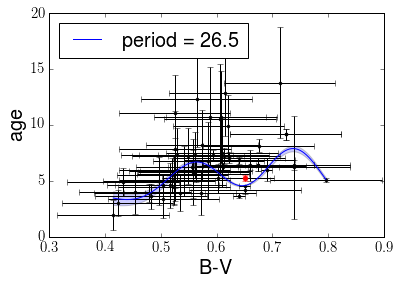

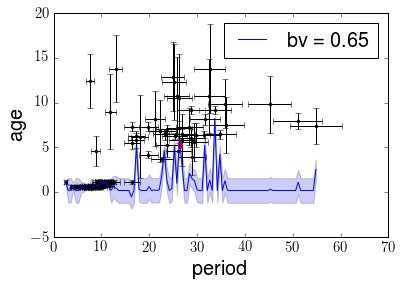

Age = 5.241571275077808 +/- 0.30081544180788594 Gyr


In [108]:
age = age_model(.65, 26.5, plot=True)